In [2]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

In [3]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    from bids import BIDSLayout
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    for epochs in epochs_all:
        print(epochs.info['sfreq'])
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

[2, 3, 5, 7, 9, 13, 14, 17, 18, 20, 21, 23, 24, 27, 29, 32, 33, 34, 37, 40, 42, 44]
[1, 4, 8, 10, 11, 12, 15, 16, 19, 22, 25, 26, 28, 30, 31, 35, 36, 38, 39, 41, 43, 45]


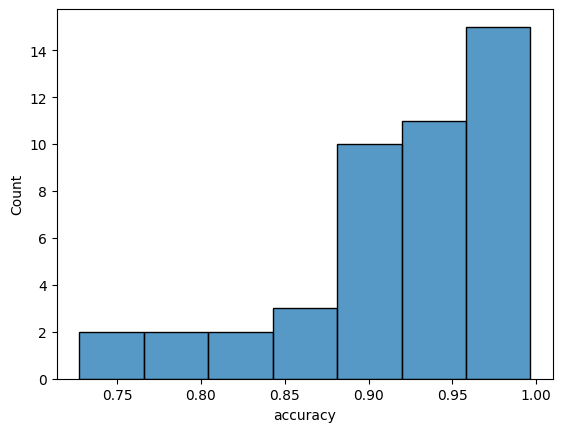

In [59]:
### Load accuracies to add to data
accuracy = pd.read_csv('accuracy.csv', index_col = 0)
sns.histplot(accuracy.accuracy)
med = np.median(accuracy.accuracy)
low_subs = list(accuracy.subject[accuracy.accuracy < med])
high_subs = list(accuracy.subject[accuracy.accuracy > med])
print(low_subs)
print(high_subs)

In [4]:
# BIDS_ROOT = '../data/bids'
# layout = BIDSLayout(BIDS_ROOT, derivatives = True, regex_search = 'forERP')
# subs = layout.get_subjects(scope = 'erp')
# subs.sort(key = int)
# evokeds = pd.DataFrame()

# for sub in subs:
    
#     # Read epochs
#     epochs = read_epochs(sub, 'forERP')
    
#     # Compute evokeds 
#     conditions = list(epochs.event_id.keys())
#     chans = ['Cz', 'Fz', 'FCz', 'CPz', 'Pz']
#     for c in conditions:
#         target = c[0]
#         tone = c[1]
#         for chan in chans:
#             uV = np.squeeze(epochs[c].average(picks = chan).get_data())
#             t = np.arange(-273, 527)

#             if int(sub) in high_subs:
#                 accuracy = 'high'
#             elif int(sub) in low_subs:
#                 accuracy = 'low'
#             # else:
#             #     accuracy = 'none'

#             d = {
#                 'sub': sub,
#                 'chan': chan,
#                 'target': target,
#                 'accuracy': accuracy,
#                 'tone': tone,
#                 'msec': t,
#                 'uV': uV
#             }

#             # Bind into dataframe
#             evoked = pd.DataFrame(d)
#             evokeds = pd.concat([evokeds, evoked])
#             evokeds = evokeds.reset_index(drop = True)
#     #         break
#     #     break
#     # break

# # Adjust units
# evokeds['uV'] = evokeds['uV'] * 1000000
# evokeds

# evokeds.to_csv('evokeds.csv', index = False) 

evokeds = pd.read_csv('evokeds.csv')

### By tone

In [82]:
evokeds_tone_1 = evokeds[evokeds.tone == 1]
evokeds_tone_2 = evokeds[evokeds.tone == 2]
evokeds_tone_3 = evokeds[evokeds.tone == 3]

Text(0.5, 1.0, 'Tone 1')

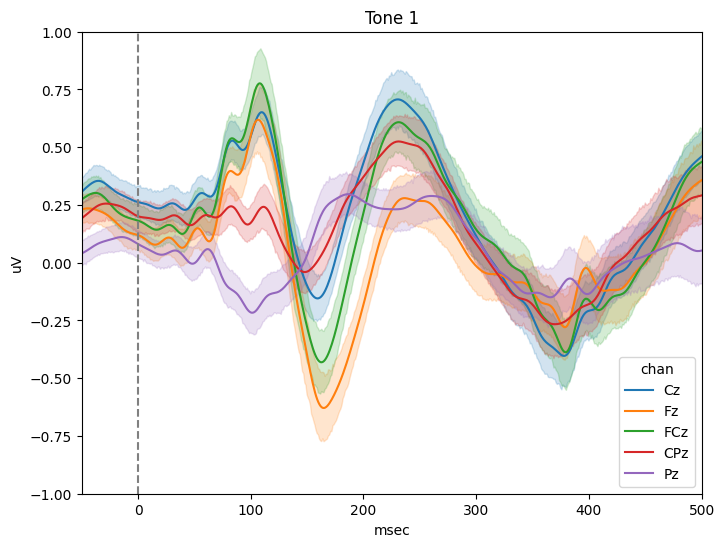

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", hue = "chan", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title("Tone 1")

### By target and tone

In [83]:
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.chan == 'Cz']
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.chan == 'Cz']
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.chan == 'Cz']

/home/letitiayhho/ipykernel_3910176/2630466430.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)


Text(0.5, 1.0, 'Tone 1')

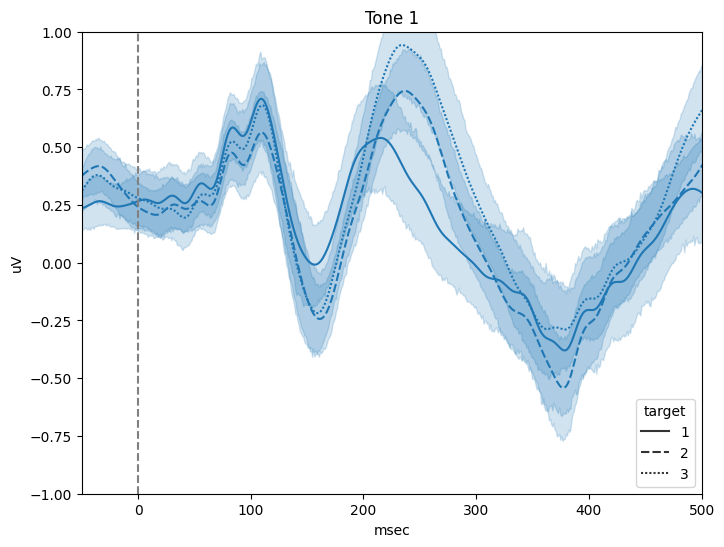

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title('Tone 1')

/home/letitiayhho/ipykernel_3910176/2877043459.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)


Text(0.5, 1.0, 'Tone 2')

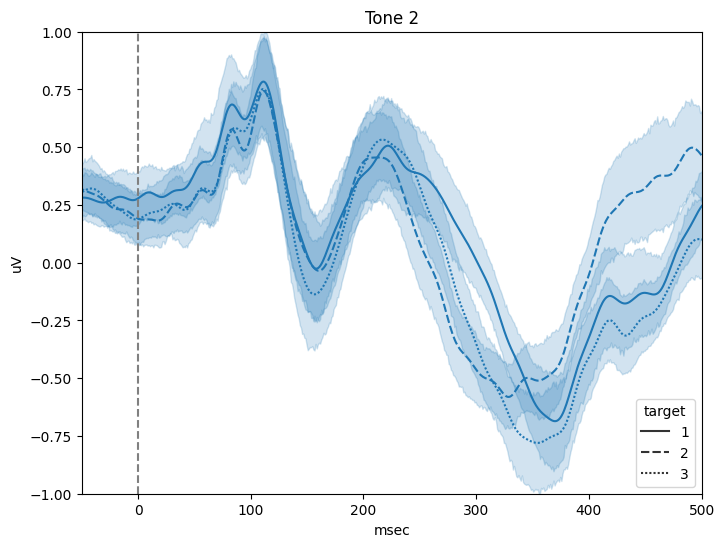

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title('Tone 2')

/home/letitiayhho/ipykernel_3910176/416824317.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)


Text(0.5, 1.0, 'Tone 3')

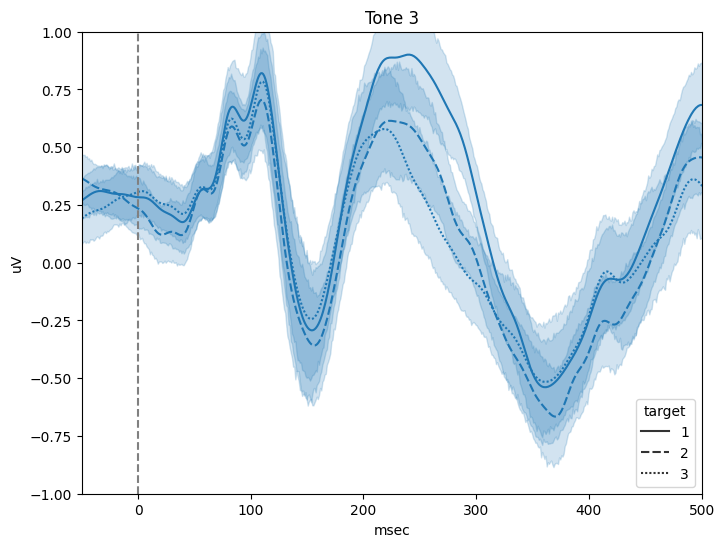

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", style = "target", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1, 1)
graph.set_title('Tone 3')

# Factor in accuracies

Text(0.5, 1.0, 'Tone 1')

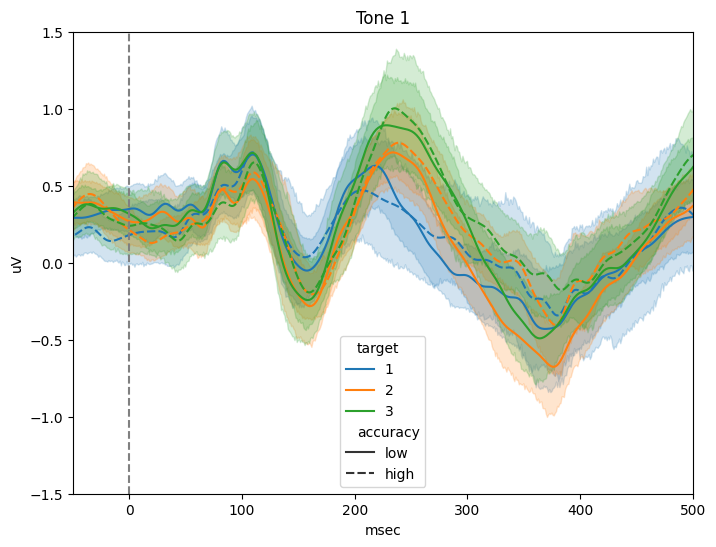

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_1, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 1')

Text(0.5, 1.0, 'Tone 2')

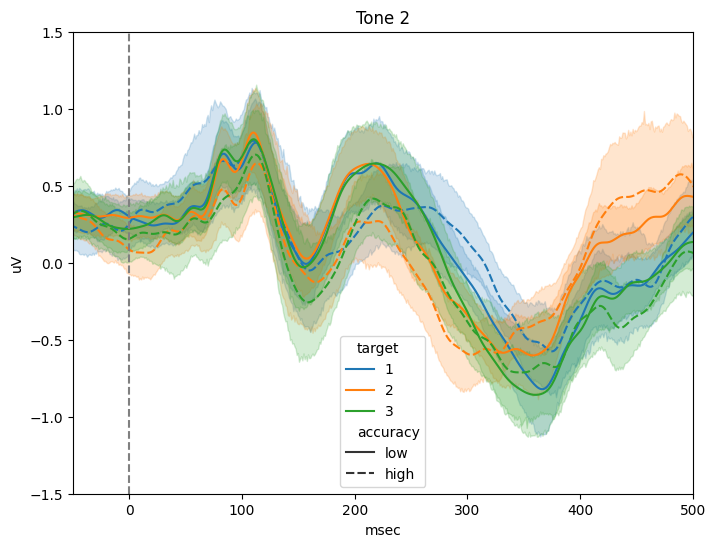

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_2, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 2')

Text(0.5, 1.0, 'Tone 3')

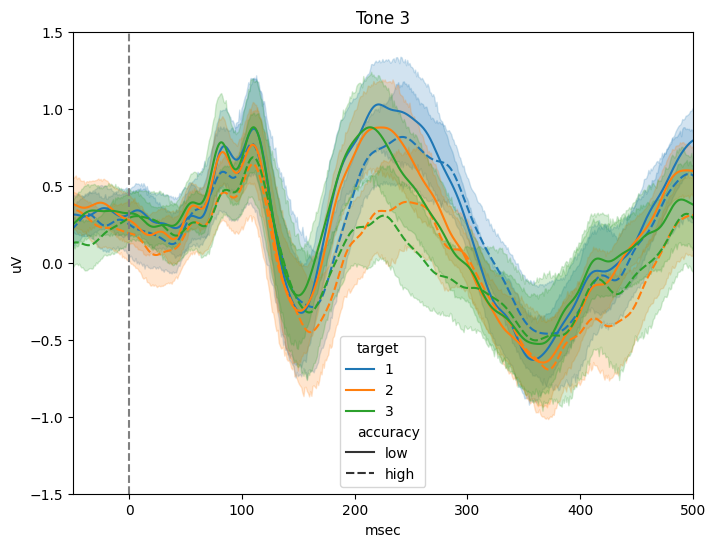

In [87]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_tone_3, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(0, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("uV")
graph.set_xlabel("msec")
graph.set_xlim(-50, 500)
graph.set_ylim(-1.5, 1.5)
graph.set_title('Tone 3')